In [1]:
import pathlib

import cdflib
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import scipy.constants
import torch
from cdasws import CdasWs

In [2]:
time = ['2016-01-01T08:52:00Z', '2016-01-01T10:52:00Z']

file_name = f"./data/wind_{time[0]}_{time[1]}_60s.npz"
if not pathlib.Path(file_name).exists():
    cdas = CdasWs()

    status, data = cdas.get_data('WI_H1_SWE', ['Proton_VX_moment', 'Proton_VY_moment', 'Proton_VZ_moment', 'Proton_Np_moment'], time[0], time[1])

    datetime = cdflib.epochs.CDFepoch().to_datetime(data.Epoch.values, to_np=True)

    velocity = np.column_stack([data.Proton_VX_moment.values,
                                data.Proton_VY_moment.values,
                                data.Proton_VZ_moment.values])
    velocity[np.any(velocity == data.Proton_VX_moment.FILLVAL, axis=1)] = np.nan
    velocity[np.any(velocity == data.Proton_VY_moment.FILLVAL, axis=1)] = np.nan
    velocity[np.any(velocity == data.Proton_VZ_moment.FILLVAL, axis=1)] = np.nan
    velocity = pd.DataFrame(velocity, index=pd.DatetimeIndex(datetime)).interpolate()
    velocity = velocity.resample("60s").mean().shift(0.5, freq="60s").interpolate()
    times = velocity.index.values

    density = data.Proton_Np_moment.values
    density[density == data.Proton_Np_moment.FILLVAL] = np.nan
    density = pd.Series(density, index=pd.DatetimeIndex(datetime)).interpolate()
    density = density.resample("60s").mean().shift(0.5, freq="60s").interpolate()

    status, data = cdas.get_data('WI_H0_MFI', ['BGSE'], time[0], time[1])

    magnetic_field = data.BGSE.values
    magnetic_field[np.any(magnetic_field == data.BGSE.FILLVAL, axis=1), :] = np.nan
    datetime = cdflib.epochs.CDFepoch().to_datetime(data.Epoch.values, to_np=True)
    magnetic_field = pd.DataFrame(magnetic_field, index=pd.DatetimeIndex(datetime)).interpolate()

    magnetic_field = magnetic_field.truncate(times[0], times[-1])
    density = density.truncate(magnetic_field.index[0], magnetic_field.index[-1]).values
    velocity = velocity.truncate(magnetic_field.index[0], magnetic_field.index[-1]).values
    times = magnetic_field.index.values

    assert len(magnetic_field) == len(velocity) == len(density)

    np.savez_compressed(file_name, magnetic_field=magnetic_field, velocity=velocity, density=density, times=times)

data = np.load(file_name)

magnetic_field = torch.as_tensor(data["magnetic_field"], dtype=torch.float32)
velocity = torch.as_tensor(data["velocity"], dtype=torch.float32)
density = torch.as_tensor(data["density"], dtype=torch.float32)
times = data["times"]

In [3]:
from pymfr.frame import estimate_ht_frame
from pymfr.axis import minimize_rdiff

electric_field = -torch.cross(velocity, magnetic_field)
frame = estimate_ht_frame(magnetic_field, electric_field)
best_axis, best_rdiff = minimize_rdiff(magnetic_field.cuda(), frame.cuda())
best_axis = best_axis.cpu()
best_rdiff = best_rdiff.cpu()

In [4]:
best_axis, best_rdiff

(tensor([ 0.3145, -0.9435,  0.1040]), tensor(0.0903))

Altitude/azimuth: 84.02777772863209 / 288.4354019165039


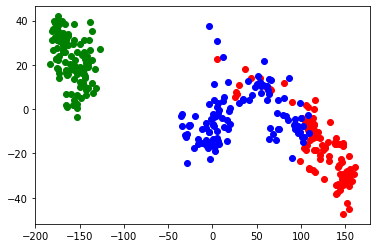

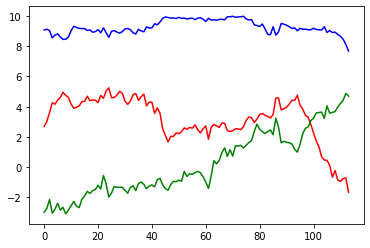

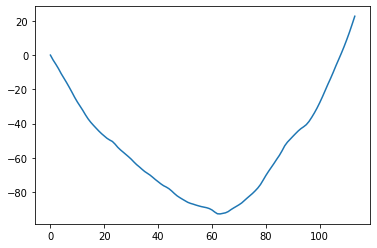

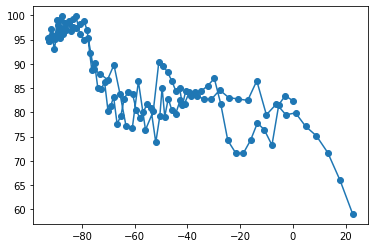

In [5]:
def spherical(x, y, z):
    altitude = np.rad2deg(np.arctan2(np.sqrt(x ** 2 + y ** 2), z))
    azimuth = np.rad2deg(np.arctan2(y, x))
    return altitude, azimuth


z_unit = np.array(best_axis)
frame = np.array(frame)

x_unit = -(frame - np.dot(frame, z_unit) * z_unit)
x_unit = x_unit / np.linalg.norm(x_unit)
y_unit = np.cross(z_unit, x_unit)
rotation_matrix = np.column_stack([x_unit, y_unit, z_unit])
rotation_matrix = rotation_matrix.T  # transpose gives inverse of rotation matrix

event_density = density.cpu().numpy()

alfven_velocity = magnetic_field / np.sqrt(scipy.constants.mu_0
                                        * scipy.constants.m_p
                                        * np.expand_dims(event_density, axis=1)) * 1e-15
remaining_flow = velocity - frame

d_flow = remaining_flow - remaining_flow.mean()
d_alfven = alfven_velocity - alfven_velocity.mean()
walen_slope = (d_flow * d_alfven).sum() / (d_alfven ** 2).sum()

# if walen_slope > 0.3:
#     continue

altitude, azimuth = spherical(*best_axis.numpy())
print("Altitude/azimuth:", altitude, "/", azimuth % 360)

colors = ["red", "green", "blue"]

for i_color, color in enumerate(colors):
    plt.scatter(alfven_velocity[:, i_color], remaining_flow[:, i_color], color=color)
plt.show()

rotated = rotation_matrix @ magnetic_field.numpy().T
for i_color, color in enumerate(colors):
    plt.plot(rotated[i_color], color=color)
plt.show()

A = scipy.integrate.cumulative_trapezoid(rotated[1], initial=0)
plt.plot(A)
plt.show()

P = rotated[2] ** 2
plt.scatter(A, P)
plt.plot(A, P)
plt.show()